## Introduction

In this report, we simulate user-product interactions within the tech products domain, guided by personality-based behavioral rules. Each user is assigned a personality profile that influences how they interact with different products, allowing us to generate realistic and diverse engagement patterns. The simulation aims to produce a sparse interaction matrix (with <10% density) suitable for collaborative filtering approaches. As a result of this simulation, we generate three key CSV files: users.csv, items.csv, and user_product_rating_matrix.csv, which will be used in the second part of the assignment to develop and evaluate personalized recommender systems.

## User Generation with Personality Profiles

In this section, we generate a synthetic dataset of 10,000 users, each assigned a unique user_id, a numeric attribute (age), a categorical attribute (profession), and a personality type. Users are divided equally into five distinct personality types, each representing unique behavioral patterns and professional backgrounds. These personas are crucial for simulating how different users interact with items based on their preferences and attributes. Below are the defined personality types:

* Tech Enthusiast: Young users (avg. age 28), mostly engineers, interested in cutting-edge technology and innovation.

* Creative Explorer: Artistic and imaginative users (avg. age 32), primarily from the arts field, drawn to creative and design-oriented content.

* Practical Buyer: Older, pragmatic users (avg. age 40) from business and law sectors, who prioritize functionality and value.

* Performance Seeker: Users with technical backgrounds (avg. age 35) in engineering and science, who focus on high performance and technical specs.

* Budget Conscious: Younger users (avg. age 25), mainly in education and business, who are sensitive to price and look for cost-efficient solutions.

For each personality, users are sampled with profession distributions and age values drawn from a normal distribution. All generated users are saved into a CSV file (users.csv) for further use in the recommender system.

In [ ]:
import random
import numpy as np
import pandas as pd

from typing import List
from dataclasses import dataclass

# Profession field options
prof_fields = ["engineering", "medicine", "education", "business", "arts", "science", "law"]

# --- Personality Descriptions ---
# 1. **Tech Enthusiast**: Mean age 28, Std Dev 5. Predominantly engineers (50%). Interested in the latest technology, gadgets, and innovations.
# 2. **Creative Explorer**: Mean age 32, Std Dev 6. Mostly from the arts field (50%). This group includes artists, musicians, and designers who seek innovative and creative products.
# 3. **Practical Buyer**: Mean age 40, Std Dev 8. Predominantly in business (30%) and law (20%). This group is more pragmatic, valuing practicality and functionality in tech products.
# 4. **Performance Seeker**: Mean age 35, Std Dev 7. A mix of engineering (30%) and science (20%). Interested in high-performance products, often involved in tech-heavy or research fields.
# 5. **Budget Conscious**: Mean age 25, Std Dev 4. Mainly in education (20%) and business (20%). This group is more cost-sensitive and values budget-friendly yet efficient tech products.

@dataclass
class User:
    user_id: str
    age: int
    profession: str
    personality: str

def generate_users_by_personality(personality_name: str, user_num: int, age_mean: float, age_std: float, prof_distro: List[float]) -> List[User]:
    """
    Generate users for a given personality.
    """
    users = []

    for i in range(user_num):
        uid = f"{personality_name[:3].lower()}_{i:04d}"
        age = max(0, int(random.gauss(age_mean, age_std)))
        profession = np.random.choice(prof_fields, p=prof_distro)
        users.append(User(user_id=uid, age=age, profession=profession, personality=personality_name))

    return users

# --- Define personalities ---

personalities_config = {
    "Tech Enthusiast": {
        "age_mean": 28,
        "age_std": 5,
        "prof_distro": [0.5, 0.05, 0.05, 0.1, 0.05, 0.2, 0.05]
    },
    "Creative Explorer": {
        "age_mean": 32,
        "age_std": 6,
        "prof_distro": [0.05, 0.05, 0.05, 0.1, 0.5, 0.1, 0.15]
    },
    "Practical Buyer": {
        "age_mean": 40,
        "age_std": 8,
        "prof_distro": [0.1, 0.2, 0.2, 0.3, 0.05, 0.05, 0.1]
    },
    "Performance Seeker": {
        "age_mean": 35,
        "age_std": 7,
        "prof_distro": [0.3, 0.05, 0.1, 0.2, 0.1, 0.2, 0.05]
    },
    "Budget Conscious": {
        "age_mean": 25,
        "age_std": 4,
        "prof_distro": [0.2, 0.1, 0.2, 0.2, 0.1, 0.1, 0.1]
    }
}

# --- Generate users per segment ---
all_users = []
users_per_segment = 2000  #number from each personallity--> 200*5=1000

for persona, config in personalities_config.items():
    users = generate_users_by_personality(
        personality_name=persona,
        user_num=users_per_segment,
        age_mean=config["age_mean"],
        age_std=config["age_std"],
        prof_distro=config["prof_distro"]
    )
    all_users.extend(users)

# --- Convert to DataFrame ---
users_df = pd.DataFrame([user.__dict__ for user in all_users])
users_df.to_csv("users.csv", index=False)
print(users_df.sample(5))


       user_id  age   profession         personality
5293  pra_1293   37     business     Practical Buyer
2102  cre_0102   29         arts   Creative Explorer
1897  tec_1897   28  engineering     Tech Enthusiast
6528  per_0528   35     medicine  Performance Seeker
668   tec_0668   32     business     Tech Enthusiast


In [ ]:
users_df.shape

(10000, 4)

## Item Generation with Rich Text and Multi-Valued Attributes

This section focuses on generating a diverse set of 1,000 tech-related items across five product categories: laptops, mice, monitors, headphones, and routers. Each item is assigned:

* A unique ID

* A realistic, 30+ word natural language description, built from category-specific templates

* A price sampled from a category-specific log-normal distribution to reflect realistic market pricing

* A multi-valued categorical feature list, sampled from a set of relevant product tags

The product descriptions are dynamically generated using structured templates and phrases specific to each category, ensuring variety and contextual richness. These descriptions simulate real-world product listings that users may read when browsing. Additionally, every item is tagged with multiple features (e.g., Bluetooth 5.0, Noise cancellation), helping create a meaningful link between items and user preferences later in the interaction matrix and recommendation phase.

The final dataset is saved in a CSV file named items.csv, which will be used in subsequent modeling tasks.

In [ ]:
import pandas as pd
import numpy as np
import random

np.random.seed(42)
random.seed(42)

num_items = 1000

# --- Structured category config ---
product_catalog = {
    "laptop": {
        "feature_phrases": ["AI-powered processor", "long battery life", "high refresh rate display", "advanced cooling system"],
        "feature_tags": ["Touchscreen", "USB-C connectivity", "Fast charging", "Expandable storage", "Bluetooth 5.0"],
        "target_users": ["for gamers", "for business professionals", "for remote workers"],
        "use_cases": ["perfect for multitasking", "great for travel", "built for performance"]
    },
    "mouse": {
        "feature_phrases": ["ergonomic design", "silent click buttons", "precision tracking", "adjustable DPI"],
        "feature_tags": ["Wireless", "Rechargeable", "Silent clicks", "Compact design"],
        "target_users": ["for graphic designers", "for office use", "for gamers"],
        "use_cases": ["ideal for everyday use", "optimized for long sessions", "great for portability"]
    },
    "monitor": {
        "feature_phrases": ["4K UHD display", "HDR10 support", "ultra-thin bezel", "anti-glare coating"],
        "feature_tags": ["4K display", "Low blue light", "HDMI connectivity", "Adjustable stand"],
        "target_users": ["for content creators", "for gamers", "for productivity setups"],
        "use_cases": ["perfect for dual-screen setups", "built for high clarity", "great for streaming"]
    },
    "headphones": {
        "feature_phrases": ["noise cancellation", "deep bass", "wireless connectivity", "long battery life"],
        "feature_tags": ["Bluetooth 5.0", "Noise cancellation", "Fast charging", "Over-ear design"],
        "target_users": ["for music lovers", "for commuters", "for gamers"],
        "use_cases": ["great for travel", "ideal for immersive sound", "perfect for calls"]
    },
    "router": {
        "feature_phrases": ["dual-band connectivity", "parental controls", "MU-MIMO support", "mesh system compatibility"],
        "feature_tags": ["Wi-Fi 6", "Gigabit ports", "Parental controls", "Mesh-ready"],
        "target_users": ["for home use", "for smart homes", "for streamers"],
        "use_cases": ["optimized for speed", "perfect for large homes", "built for low latency"]
    }
}

# --- Description Templates ---
description_templates = [
    "This {product_type} features {feature_1} and {feature_2}, designed {target_user}. It is {use_case}, offering reliable performance and user comfort.",
    "Designed {target_user}, this {product_type} includes {feature_1} and {feature_2}. It’s {use_case} and built for high efficiency.",
    "With {feature_1} and {feature_2}, this {product_type} is {use_case}. Perfect {target_user}, it delivers top-tier functionality.",
    "{product_type_cap} comes equipped with {feature_1} and {feature_2}, making it {use_case}. Great choice {target_user}."
]

# --- Item generation ---
item_ids = [f"item_{i:04d}" for i in range(1, num_items + 1)]
descriptions = []
prices = []
features_list = []
product_types_used = []

for _ in range(num_items):
    # Select a product category
    prod_type = random.choice(list(product_catalog.keys()))
    config = product_catalog[prod_type]

    # Randomly sample attributes
    phrase_1, phrase_2 = random.sample(config["feature_phrases"], 2)
    target_user = random.choice(config["target_users"])
    use_case = random.choice(config["use_cases"])

    # Randomly select a description template
    template = random.choice(description_templates)
    description = template.format(
        product_type=prod_type,
        product_type_cap=prod_type.title(),
        feature_1=phrase_1,
        feature_2=phrase_2,
        target_user=target_user,
        use_case=use_case
    )
    descriptions.append(description)
    product_types_used.append(prod_type)

    # Price (log-normal)
    # Category-specific log-normal price sampling
    price_params = {
        "laptop":      {"mean": 6.5, "sigma": 0.5, "min": 100, "max": 3000},
        "mouse":       {"mean": 3.8, "sigma": 0.45,  "min": 20,  "max": 150},
        "monitor":     {"mean": 5.0, "sigma": 0.35, "min": 80,  "max": 1000},
        "headphones":  {"mean": 4.2, "sigma": 0.45, "min": 40,  "max": 600},
        "router":      {"mean": 4.5, "sigma": 0.4,  "min": 50,  "max": 700}
    }

    p = price_params[prod_type]
    price = round(np.clip(np.random.lognormal(mean=p["mean"], sigma=p["sigma"]), p["min"], p["max"]), 2)
    prices.append(price)

    # Features (2 to 4 from category-specific list)
    feat_tags = random.sample(config["feature_tags"], k=random.randint(2, min(4, len(config["feature_tags"]))))
    features_list.append(", ".join(feat_tags))

# --- Final DataFrame ---
items_df = pd.DataFrame({
    "item_id": item_ids,
    "product_type": product_types_used,
    "description": descriptions,
    "price": prices,
    "features": features_list
})

# Preview
print(items_df.sample(3))
items_df.to_csv("items.csv", index=False)


       item_id product_type  \
541  item_0542        mouse   
466  item_0467      monitor   
181  item_0182   headphones   

                                           description   price  \
541  This mouse features precision tracking and erg...   26.89   
466  Monitor comes equipped with HDR10 support and ...  184.00   
181  With noise cancellation and long battery life,...   45.34   

                                              features  
541                       Compact design, Rechargeable  
466  Adjustable stand, Low blue light, HDMI connect...  
181      Over-ear design, Fast charging, Bluetooth 5.0  


In [ ]:
items_df.head()

,item_id,product_type,description,price,features
0,item_0001,laptop,"Designed for business professionals, this lapt...",852.66,"Touchscreen, Bluetooth 5.0"
1,item_0002,router,"Designed for home use, this router includes me...",85.17,"Wi-Fi 6, Parental controls"
2,item_0003,mouse,"With adjustable DPI and ergonomic design, this...",59.83,"Rechargeable, Silent clicks"
3,item_0004,headphones,"With wireless connectivity and deep bass, this...",132.34,"Bluetooth 5.0, Noise cancellation"
4,item_0005,laptop,This laptop features high refresh rate display...,591.65,"Expandable storage, Touchscreen, USB-C connect..."


In [ ]:
items_df.describe()

,price
count,1000.000000
mean,222.717360
std,322.331852
min,20.000000
25%,54.542500
50%,89.655000
75%,188.867500
max,2070.090000


In [ ]:
items_df[items_df['product_type']=='laptop'].head()

,item_id,product_type,description,price,features
0,item_0001,laptop,"Designed for business professionals, this lapt...",852.66,"Touchscreen, Bluetooth 5.0"
4,item_0005,laptop,This laptop features high refresh rate display...,591.65,"Expandable storage, Touchscreen, USB-C connect..."
6,item_0007,laptop,Laptop comes equipped with long battery life a...,1464.99,"Fast charging, USB-C connectivity, Expandable ..."
13,item_0014,laptop,With high refresh rate display and advanced co...,255.54,"USB-C connectivity, Expandable storage, Touchs..."
19,item_0020,laptop,"Designed for remote workers, this laptop inclu...",328.27,"USB-C connectivity, Touchscreen, Expandable st..."


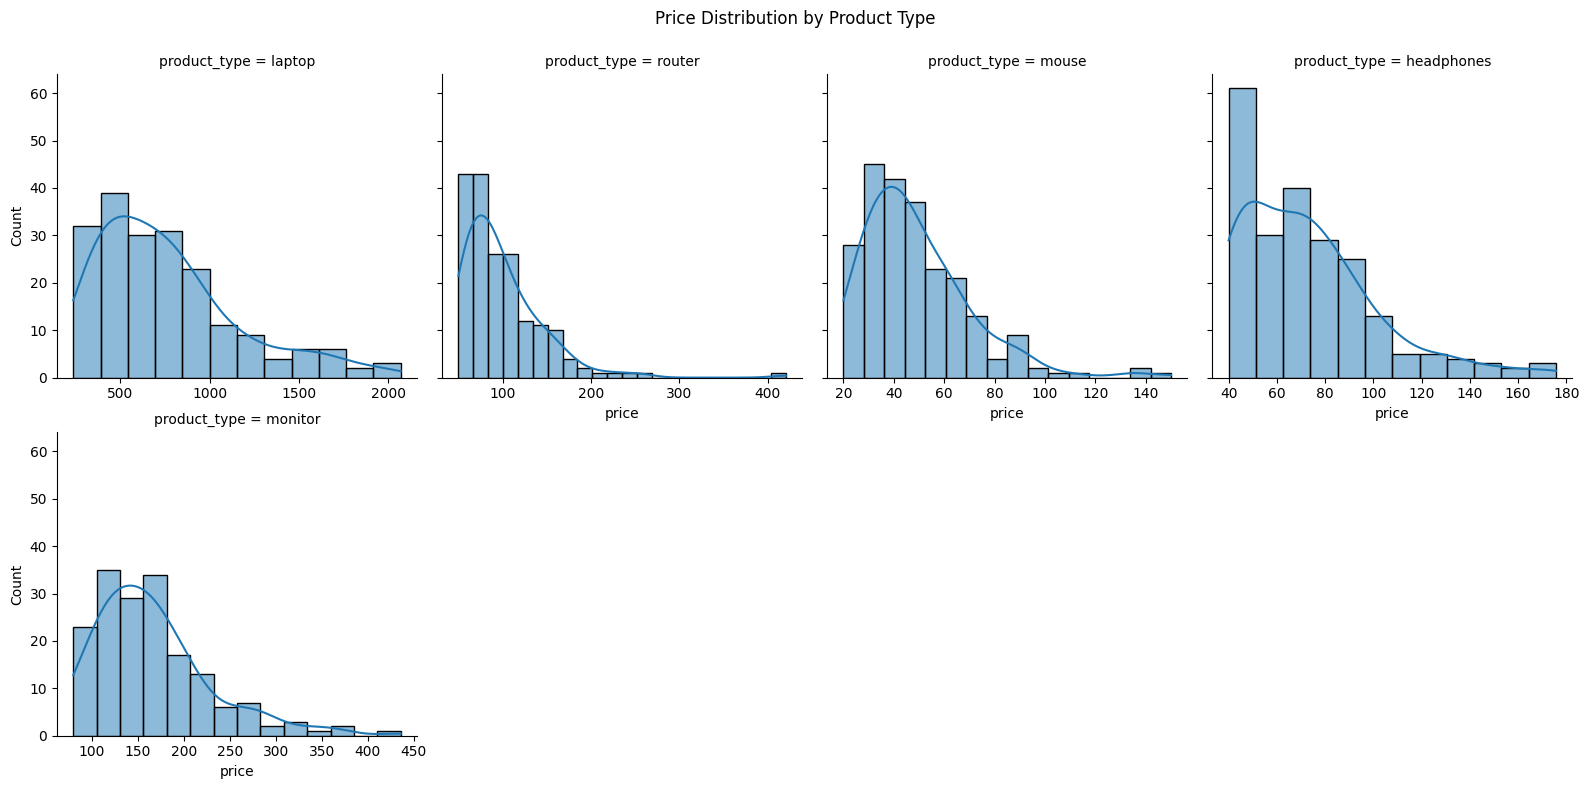

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(items_df, col='product_type', col_wrap=4, height=4, sharex=False)
g.map(sns.histplot, 'price', kde=True)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Price Distribution by Product Type')
plt.show()


In [ ]:
items_df.shape

(1000, 5)

## Personality-Driven Interaction Rules: Simulating Realistic User-Product Ratings

This section simulates a binary user-item interaction matrix by mapping user personalities to products using rule-based logic. Each user interacts (rating = 1) or does not interact (rating = 0) with a product based on how well its features, description, and price align with their preferences. Ratings are further fuzzified with a small probability of randomness to simulate real-world unpredictability.

Below is a high-level breakdown of how each personality type interacts with products:


**Tech Enthusiast**

* Values innovation, advanced tech, and modern connectivity.

* Looks for keywords like AI-powered, Bluetooth, 4K, and mesh-ready.

* Tends to favor performance-heavy, cutting-edge gear.

* Slight preference for older users who appreciate high-end specs.

**Creative Explorer**

* Prioritizes ergonomics, design comfort, and visual clarity.

* Drawn to descriptions like for content creators, portable, and anti-glare.

* Seeks creative tools with high-resolution displays and visual fidelity.

* More favored by younger users inspired by freedom and creativity.

**Practical Buyer**

* Focuses on usefulness, reliability, and family-friendly features.

* Likes terms such as ideal for everyday use, wireless, and parental controls.

* Appreciates affordability without compromising on functionality.

* Older users are slightly more likely to match this personality.

**Performance Seeker**

* Targets gaming-grade, high-efficiency, or long-lasting gear.

* Keywords like high refresh rate, built for performance, and expandable storage are strong positives.

* Needs gear that can keep up with intense or prolonged use.

* Younger users dominate this group, valuing power and performance.

**Budget Conscious**
Looks for compact, basic, and multi-use products at a low cost.

* Favors tags like great for travel, fast charging, and ideal for everyday use.

* Still values features like wireless or noise cancellation, but prioritizes affordability.

* Very price-sensitive, especially if under a certain age.

The rating engine reflects nuanced user behavior by incorporating age-based tendencies, feature preference checks, textual analysis of descriptions, and price sensitivity thresholds. This results in a synthetic interaction matrix that realistically captures how different buyer personas in an e-commerce environment.


In [ ]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar

# Sample user and product data for testing
users_df = pd.read_csv("users.csv")  # Assuming this file was created previously
items_df = pd.read_csv("items.csv")  # Assuming this file was created previously

# --- Define rating logic for each personality ---
def calculate_rating(user, product):
    """
    Calculate binary rating (1 for positive interaction, 0 for no interaction)
    for each product based on the personality and product attributes.
    """
    # Initialize a score counter
    score = 0

    # Split the features string into a list of features for easier processing
    product_features = product["features"].lower().split(", ")

    # Retrieve personality-based conditions and price limit logic
    price_limits = {
        "Tech Enthusiast": {
            "laptop": 2000, "monitor": 350, "mouse": 100, "headphones": 140, "router": 220
        },
        "Creative Explorer": {
            "laptop": 1400, "monitor": 300, "mouse": 90, "headphones": 110, "router": 130
        },
        "Practical Buyer": {
            "laptop": 900, "monitor": 250, "mouse": 80, "headphones": 80, "router": 100
        },
        "Performance Seeker": {
            "laptop": 1800, "monitor": 350, "mouse": 120, "headphones": 160, "router": 240
        },
        "Budget Conscious": {
            "laptop": 700, "monitor": 170, "mouse": 50, "headphones": 50, "router": 70
        }
    }

    # Adjust the price limit according to user personality and product type
    price_limit = price_limits[user.personality].get(product["product_type"], 0)

    # Price check
    if product["price"] <= price_limit:
        score += 1  # Bonus for affordable product within the user's price range

    # Now, based on user personality, check description and features
    if user.personality == "Tech Enthusiast":
        # Check if the product has advanced features like AI-powered processors or performance-based descriptions
        if "ai-powered processor" in product_features or "built for performance" in product["description"]:
            score += 1.5  # AI or performance features are attractive to tech enthusiasts
        # Check if the product supports 4K display or HDR10, as these are important for tech enthusiasts
        if "4k" in product_features or "hdr10 support" in product["description"]:
            score += 1  # 4K or HDR10 features are highly desirable for a tech enthusiast
        # Check if the product has Bluetooth or wireless connectivity, which are common features in tech products
        if "bluetooth" in product_features or "wireless connectivity" in product["description"]:
            score += 1  # Bluetooth and wireless connectivity are essential for modern tech enthusiasts
        # Replaced profession check with a rule based on product description
        if "great for streaming" in product["description"]:
            score += 0.5  # Tech enthusiasts often align with content creation and appreciate creator-friendly features
        # Check if the product emphasizes performance, as tech enthusiasts value high performance in tech products
        if "performance" in product["description"]:
            score += 1  # Products designed for high performance, like gaming laptops, high refresh rate monitors, etc.
        # Check for cutting-edge features such as high refresh rates, which are important for tech enthusiasts
        if "high refresh rate" in product_features or "dual-band connectivity" in product["description"] or "mesh-ready" in product_features:
            score += 1  # High refresh rate displays are important to tech enthusiasts, especially for gaming and media work
        if user.age<28: #Mostly liked by older users
          score -= 1




    elif user.personality == "Creative Explorer":
        # Check if the product has ergonomic or compact design, which is important for long creative sessions
        if "ergonomic design" in product["description"] or "compact design" in product["description"]:
            score += 1  # Ergonomic or compact design is essential for comfort during long creative work sessions
        # Bonus for products targeting graphic designers or artists
        if "graphic designers" in product["description"] or "artists" in product["description"]:
            score += 1  # Bonus for products targeting design-focused professionals
        # Eye-care features like low blue light or anti-glare coating, useful for designers and creators
        if "low blue light" in product_features or "anti-glare coating" in product["description"]:
            score += 1  # Eye-care features are highly desirable for those working long hours in front of screens
        # Replaced profession check with a creative-friendly feature from the description
        if "for graphic designers" in product["description"] or "for content creators" in product["description"]:
            score += 1  # Products targeting creative professionals like designers or creators
        # Check if the product is described as portable, which is important for creative professionals who travel
        if "perfect for travel" in product["description"]:
            score += 0.5  # Portable products are ideal for creative professionals on the go
        # New Rule: Bonus for high-resolution displays or color accuracy features
        if "4k" in product["description"] or "high resolution" in product["description"]:
            score += 1  # High-resolution displays are crucial for creatives to see their work in detail
        if "for productivity setups" in product["description"] or "built for high clarity" in product["description"]:
            score += 1.5  # Color accuracy is essential for creatives working on design, photography, or art
        if user.age>28: #Mostly liked by younger users
          score -= 1



    elif user.personality == "Practical Buyer":
        # Check if the product has wireless functionality (important for ease of use and minimal cable clutter)
        if "wireless" in product_features:
            score += 1.5  # Bonus for wireless functionality, which is more practical and versatile
        # Check if the product is described as ideal for everyday use (something practical for regular tasks)
        if "ideal for everyday use" in product["description"]:
            score += 1  # Products designed for everyday use are seen as more practical and reliable
        # Bonus if the product targets business professionals (practical for work-related tasks)
        if "business professionals" in product["description"]:
            score += 1.5  # Business professionals need practical products for productivity and efficiency
        # Check if the product has features like parental controls or mesh system compatibility (ideal for home/family use)
        if "parental controls" in product_features or "mesh system compatibility" in product["description"]:
            score += 1  # Important for family or home-use products, such as routers, which are practical for family setups
        # Check if the product is described as great for portability (important for those who need convenience)
        if "great for portability" in product["description"]:
            score += 1.5  # Portability is key for practical buyers who need products they can easily move or carry around
        # Bonus for products that are durable and built to last (practical buyers value longevity and reliability)
        if "durable" in product["description"] or "long-lasting" in product["description"]:
            score += 1  # Durability is a major factor for practical buyers, who prefer long-lasting products
        if user.age<40: #Mostly liked by older users
          score -= 1


    elif user.personality == "Performance Seeker":
        # Check for high-performance features like high refresh rate or performance-oriented features
        if "high refresh rate display" in product["description"] or "performance" in product_features:
            score += 1  # High performance features are essential for this personality, especially for gaming or intensive tasks
        # Check if the product offers long battery life or fast charging (important for long gaming sessions or work)
        if "long battery life" in product["description"] or "fast charging" in product["description"]:
            score += 0.5  # Battery life and charging speed are important for performance seekers who need power during long sessions
        # Check if the product is built for performance, especially for gaming or high-demand tasks
        if "built for performance" in product["description"] or "gamers" in product["description"]:
            score += 1  # Products described as built for performance or targeting gamers will be highly rated
        # Check if the product features advanced cooling systems (important for high-performance use like gaming laptops)
        if "advanced cooling system" in product["description"]:
            score += 0.5  # Advanced cooling helps ensure optimal performance during intense tasks like gaming or heavy workloads
        # Check for expandable storage (important for users who need more storage for games or large projects)
        if "expandable storage" in product_features:
            score += 1  # Expandable storage is a feature highly valued by performance seekers for storing large files or games
        # Check if the product is targeted at remote workers (combining performance with portability)
        if "for remote workers" in product["description"]:
            score += 1  # Performance seekers who are also remote workers will appreciate a balance of high performance and portability
        if user.age>30: #Mostly liked by younger users
          score -= 1



    elif user.personality == "Budget Conscious":
        # Check for wireless products, which are often more practical and affordable for budget-conscious users
        if "wireless" in product_features:
            score += 1  # Bonus for wireless products, which are popular for their convenience
        # Simple, basic products are more appealing to budget-conscious users
        if "basic" in product["description"]:
            score += 1  # Bonus for simple, reliable products without unnecessary complexity
        # Compact products are often more affordable and practical for everyday use
        if "compact" in product_features:
            score += 1.5  # Bonus for compact products, which tend to be more affordable
        # Everyday use products are practical and affordable, making them ideal for budget-conscious users
        if "ideal for everyday use" in product["description"]:
            score += 2  # Bonus for products that are practical and meant for daily use
        # # Check for price-sensitive features that make the product more budget-friendly
        # if product["price"] <= 300:  # If the product is under $300, it's a good fit for budget-conscious users
        #     score += 1  # Major bonus for budget-friendly products
        # Check if the product is portable, as budget-conscious users often prioritize products that are easy to move around
        if "great for travel" in product["description"]:
            score += 1  # Bonus for portable products, which are often more affordable and versatile
        if "noise cancellation" in product["description"] or "perfect for calls" in product["description"] :
            score += 1.5
        if "fast charging" in product_features:
            score += 1.5
        if user.age>24: #Mostly liked by younger users
          score -= 1


    # Define a threshold to determine if the user will interact with the product
    threshold = 3.5  # If the score exceeds 3 points, assign rating of 1
    rating = 1 if score >= threshold else 0

    # 10% chance to change the rating to the opposite value
    if random.random() < 0.05:  # 10% probability
        rating = 1 - rating  # Flip the rating (0 becomes 1, 1 becomes 0)

    return rating


# --- Generate ratings for each user and product ---
ratings_data = []

# Use tqdm to show a progress bar while processing users and products
for _, user in tqdm(users_df.iterrows(), total=users_df.shape[0], desc="Generating Ratings for Users"):
    for _, product in items_df.iterrows():
        rating = calculate_rating(user, product)

        # Store the rating data
        ratings_data.append({
            "user_id": user["user_id"],
            "product_id": product["item_id"],
            "rating": rating,
            "personality": user["personality"]
        })

# Convert ratings data to DataFrame
ratings_df = pd.DataFrame(ratings_data)

# --- Preview Results ---
print(ratings_df.sample(5))
#ratings_df.to_csv("rating.csv", index=False)  # Save to CSV file


Generating Ratings for Users: 100%|██████████| 10000/10000 [19:54<00:00,  8.37it/s]


          user_id product_id  rating         personality
7127720  per_1127  item_0721       0  Performance Seeker
9121573  bud_1121  item_0574       0    Budget Conscious
4939134  pra_0939  item_0135       0     Practical Buyer
5918741  pra_1918  item_0742       0     Practical Buyer
6271605  per_0271  item_0606       1  Performance Seeker


### Interaction Statistics & Sparsity Check

To ensure the generated dataset adheres to best practices in recommender system design, we analyze the distribution of positive interactions (i.e., user-product ratings with a value of 1) across all personality types and in aggregate.

A common guideline in collaborative filtering models is to maintain sparsity below 10%, meaning that less than 10% of the total possible user-item pairs should have a positive interaction. This reflects the realistic nature of user engagement, where most users interact with only a small subset of products.

To validate this, we calculate and print:

The number and percentage of positive ratings per personality type

The overall total of positive interactions across the entire dataset

This step helps confirm that the rule-based interaction engine generates sufficiently sparse data, mimicking real-world recommendation scenarios and avoiding overly dense user behavior, which could lead to unrealistic recommendation performance.

In [ ]:
# Calculate the number of positive ratings per personality
positive_ratings_by_personality = ratings_df.groupby('personality')['rating'].sum()

# Calculate the total number of ratings per personality
total_ratings_by_personality = ratings_df.groupby('personality')['rating'].count()

# Calculate the percentage of positive ratings per personality
positive_percentage_by_personality = (positive_ratings_by_personality / total_ratings_by_personality) * 100

# Calculate overall positive ratings and total ratings
overall_positive_ratings = ratings_df['rating'].sum()
overall_total_ratings = ratings_df.shape[0]

# Calculate overall percentage of positive ratings
overall_positive_percentage = (overall_positive_ratings / overall_total_ratings) * 100

# Display the positive ratings out of total ratings and percentage per personality
print("Positive Ratings and Percentage per Personality:")
for personality in positive_ratings_by_personality.index:
    positive = positive_ratings_by_personality[personality]
    total = total_ratings_by_personality[personality]
    percentage = positive_percentage_by_personality[personality]
    print(f"{personality}: {positive}/{total} positive ratings ({percentage:.2f}%)")

# Display overall positive ratings and percentage
print(f"\nOverall Positive Ratings: {overall_positive_ratings}/{overall_total_ratings} ({overall_positive_percentage:.2f}%)")


Positive Ratings and Percentage per Personality:
Budget Conscious: 210502/2000000 positive ratings (10.53%)
Creative Explorer: 183453/2000000 positive ratings (9.17%)
Performance Seeker: 216498/2000000 positive ratings (10.82%)
Practical Buyer: 193456/2000000 positive ratings (9.67%)
Tech Enthusiast: 154311/2000000 positive ratings (7.72%)

Overall Positive Ratings: 958220/10000000 (9.58%)


In [ ]:
ratings_df.head()

,user_id,product_id,rating,personality
0,tec_0000,item_0001,0,Tech Enthusiast
1,tec_0000,item_0002,0,Tech Enthusiast
2,tec_0000,item_0003,0,Tech Enthusiast
3,tec_0000,item_0004,0,Tech Enthusiast
4,tec_0000,item_0005,0,Tech Enthusiast


In [ ]:
import pandas as pd

# Assuming ratings_df is already defined with columns: user_id, product_id, rating, personality

rating_matrix = ratings_df.pivot(index="user_id", columns="product_id", values="rating")
rating_matrix = rating_matrix.fillna(0)

In [ ]:
# Reset index to include user_id as a column
user_product_rating_matrix = rating_matrix.reset_index()
# Save to CSV
user_product_rating_matrix.to_csv("user_product_rating_matrix.csv", index=False)